# Fig 2: frequency band definitions gif

This notebook creates an animated visualizer showing how frequency band ranges can affect estimates.

Based on Fig 2 (a-e) of the oscillation methods paper. 

ToDo:
- add labels to bar plots
- add ylims to bar plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from fooof import Bands

from neurodsp.filt import filter_signal
from neurodsp.sim import sim_powerlaw, sim_oscillation
from neurodsp.spectral import compute_spectrum, trim_spectrum

In [2]:
import seaborn as sns
sns.set_context('poster')

In [3]:
# Import custom code
from code.utils import compute_abs_power
from code.plts import plot_bar, plot_spectra, plot_timeseries
from code.gif import clear_output, _gif_plot_output

## SETTINGS

In [4]:
# Simulation settings
n_seconds = 10
fs = 1000
exp = -1
cf = 10

In [5]:
# Plot settings
f_range = [2, 75]

In [6]:
# Define band ranges
BANDS = Bands({'theta' : [4, 8],
               'alpha' : [8, 12],
               'beta' : [12, 25]})

alpha_color = '#1882d9'

## DEFINE AXES

In [7]:
def make_axes():
    
    fig = plt.figure(figsize=(12, 4), constrained_layout=True)
    gs = fig.add_gridspec(2, 5)
    ax1 = fig.add_subplot(gs[0:, 0:2])
    ax2 = fig.add_subplot(gs[0, 2:])
    ax3 = fig.add_subplot(gs[1, 2])
    ax4 = fig.add_subplot(gs[1, 3])
    ax5 = fig.add_subplot(gs[1, 4])
    
    return fig, ax1, ax2, [ax3, ax4, ax5]

## SIMULATE SIGNAL

In [8]:
# ...
ap = sim_powerlaw(n_seconds, fs, exp)
osc1 = sim_oscillation(n_seconds, fs, cf)

In [9]:
sig1 = ap + osc1

In [10]:
#
step = 0.1
cfs = np.concatenate([np.arange(10, 12.6, step),
                      np.arange(12.4, 7.5, -step),
                      np.arange(7.5, 10, step)])

In [11]:
#cfs = np.array([10, 9, 8, 7, 6])
cfs = np.array([10, 9, 8, 7, 6, 7, 8, 9, 10, 11, 12, 13, 14, 13, 12, 11])
sig2s = []
for cf in cfs:
    sig2s.append(ap + sim_oscillation(n_seconds, fs, cf))

## EXAMPLE PLOT

In [12]:
sig2 = sig2s[-1]
freqs1, powers1 = trim_spectrum(*compute_spectrum(sig1, fs), f_range)
freqs2, powers2 = trim_spectrum(*compute_spectrum(sig2, fs), f_range)

filt1 = filter_signal(sig1, fs, 'bandpass', BANDS['alpha'])
filt2 = filter_signal(sig2, fs, 'bandpass', BANDS['alpha'])

bp1 = {label : compute_abs_power(freqs1, powers1, band) for label, band in BANDS}
bp2 = {label : compute_abs_power(freqs2, powers2, band) for label, band in BANDS}

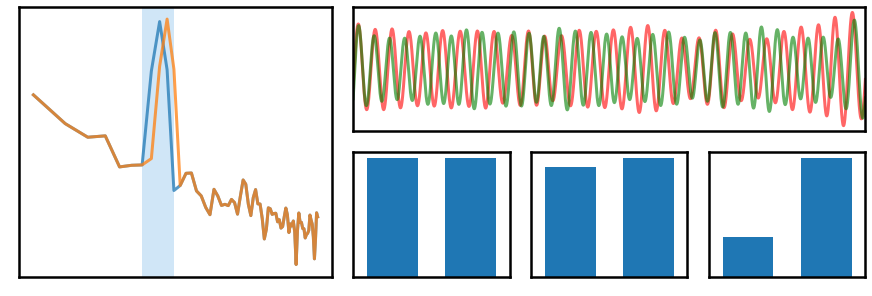

In [13]:
fig, ax1, ax2, bar_axes = make_axes()
plot_spectra(freqs1, [powers1, powers2], alpha=0.75, 
             shade_ranges=[BANDS.alpha], shade_colors=[alpha_color], ax=ax1)
plot_timeseries([filt1, filt2], colors=['red', 'green'],
                xlim=[5000, 8000], alpha=0.6, ax=ax2)
for (label, _), ax in zip(BANDS, bar_axes):
    plot_bar(bp1[label], bp2[label], ax=ax)

## BUILDER FUNCTION

In [14]:
def build_all(sig1, sig2s, sleep=0.15, n_build=20, save=False):
    
    ## Setup
    # Precompute measures for sig1
    freqs, pows1 = compute_spectrum(sig1, fs)
    filt1 = filter_signal(sig1, fs, 'bandpass', BANDS['alpha'])
    bp1 = {}
    for label, band in BANDS:
        bp1[label] = compute_abs_power(freqs, pows1, band)
    
    # Precompute measures for sig2
    filt2s, pow2s, bp2s = [], [], []
    for sig in sig2s:
        filt2s.append(filter_signal(sig, fs, 'bandpass', BANDS['alpha']))
        cur_freqs, cur_powers = compute_spectrum(sig, fs)
        pow2s.append(cur_powers)
        bp2s.append({label : compute_abs_power(cur_freqs, cur_powers, band) for label, band in BANDS})
        
        
    ## Create builds
    for b_ind, filt2, pows2, bp2 in zip(range(n_build), filt2s, pow2s, bp2s):
        
        clear_output(wait=True)
        
        fig, ax1, ax2, bar_axes = make_axes()
        
        plot_spectra(freqs, [pows1, pows2], alpha=0.75,
                     shade_ranges=[[8, 12]], shade_colors=[alpha_color], 
                     ax=ax1)
        plot_timeseries([filt1, filt2], colors=['red', 'green'],
                        xlim=[5000, 8000], alpha=0.6, ax=ax2)
        
        for (label, _), ax in zip(BANDS, bar_axes):
            plot_bar(bp1[label], bp2[label], ax=ax)

        _gif_plot_output(fig, save, b_ind, 'fig2', sleep)

## ANIMATED PLOT

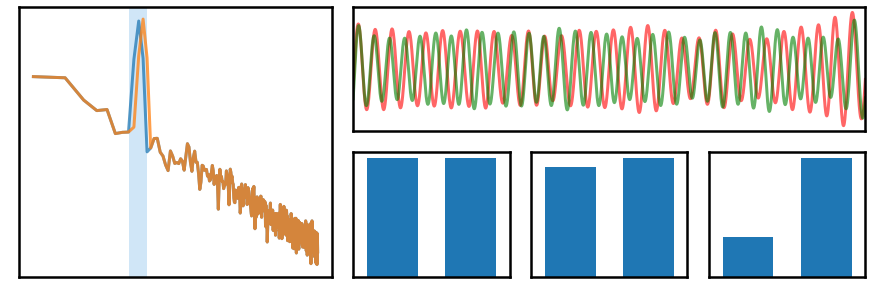

In [15]:
build_all(sig1, sig2s)